# Player Market Value Prediction: Applied ML 2025 Final Project

In this notebook, we predict football players' market values using player stats, demographics, and performance data.  
We use the helper functions from `utils.py` to keep our workflow modular and clean.


In [1]:
# Import libraries and utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import load_all, aggregate_player_stats, get_latest_valuation, merge_player_data, plot_distribution, \
    fillna_and_scale, encode_categorical, scatter_actual_vs_pred, compute_age

# Set pandas options for nicer display
pd.set_option('display.max_columns', 100)


## 1. Data Loading

First, we load all the relevant tables from the dataset using our utility functions.


In [2]:
# Load all data as a dictionary of DataFrames
data = load_all()
for name, df in data.items():
    print(f"{name}: {df.shape}")


appearances: (1706806, 13)
clubs: (439, 17)
club_games: (148052, 11)
competitions: (44, 11)
games: (74026, 23)
game_events: (1035043, 10)
game_lineups: (2191911, 10)
players: (32601, 23)
player_valuations: (496606, 5)
transfers: (79646, 10)


## 2. Data Preprocessing & Feature Table Creation

We aggregate player stats, get the latest player valuation, and merge everything into a single table.


In [3]:
# Aggregate stats and get latest valuations
stats = aggregate_player_stats(data['appearances'])
latest_val = get_latest_valuation(data['player_valuations'])

# Merge into main DataFrame
main_df = merge_player_data(data['players'], stats, latest_val)
main_df = main_df.drop(columns='market_value_in_eur_x') \
                 .rename(columns={'market_value_in_eur_y': 'market_value_in_eur'})


display(main_df.head(20))
print(main_df.shape)


,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,highest_market_value_in_eur,n_games,total_yellow,total_red,market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,30000000.0,136.0,19.0,0.0,1000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,8000000.0,152.0,4.0,2.0,750000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,34500000.0,122.0,11.0,1.0,1000000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,24500000.0,4.0,0.0,0.0,200000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,3000000.0,12.0,0.0,0.0,100000.0
5,109,NaN,Dedê,Dedê,2013,825,dede,Brazil,Belo Horizonte,Brazil,1978-04-18 00:00:00,Left-Back,Defender,NaN,NaN,NaN,Football Concept,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dede/profil/sp...,TR1,Eskisehirspor,9500000.0,41.0,4.0,0.0,400000.0
6,123,Christoph,Metzelder,Christoph Metzelder,2012,33,christoph-metzelder,Germany,Haltern,Germany,1980-11-05 00:00:00,Centre-Back,Defender,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/christoph-metz...,L1,FC Schalke 04,9500000.0,7.0,0.0,0.0,1500000.0
7,132,Tomas,Rosicky,Tomas Rosicky,2015,11,tomas-rosicky,CSSR,Praha,Czech Republic,1980-10-04 00:00:00,Attacking Midfield,Midfield,both,179.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tomas-rosicky/...,GB1,Arsenal Football Club,17500000.0,77.0,13.0,0.0,350000.0
8,162,Marc,Ziegler,Marc Ziegler,2012,79,marc-ziegler,Germany,Blieskastel,Germany,1976-06-13 00:00:00,Goalkeeper,Goalkeeper,right,193.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/marc-ziegler/p...,L1,Verein für Bewegungsspiele Stuttgart 1893,1250000.0,NaN,NaN,NaN,200000.0
9,215,Roque,Santa Cruz,Roque Santa Cruz,2015,1084,roque-santa-cruz,Paraguay,Asunción,Paraguay,1981-08-16 00:00:00,Centre-Forward,Attack,right,193.0,2023-12-31 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roque-santa-cr...,ES1,Málaga CF,12000000.0,109.0,3.0,0.0,250000.0


(32601, 26)


## 3. Exploratory Data Analysis (EDA)

Let’s examine the distribution of market values, relationships with age, and other interesting patterns.


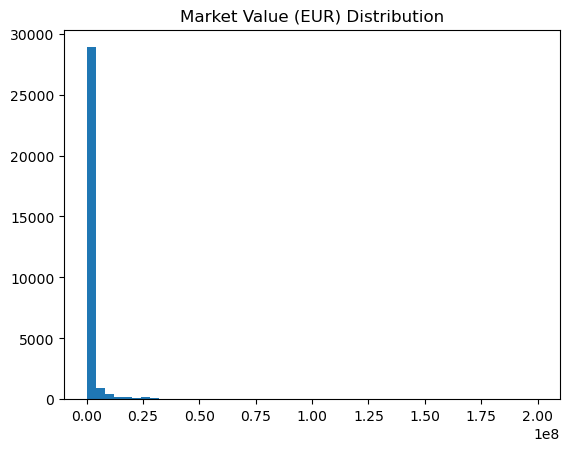

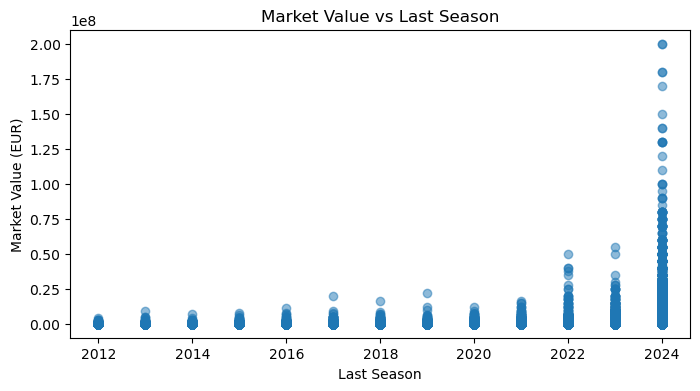

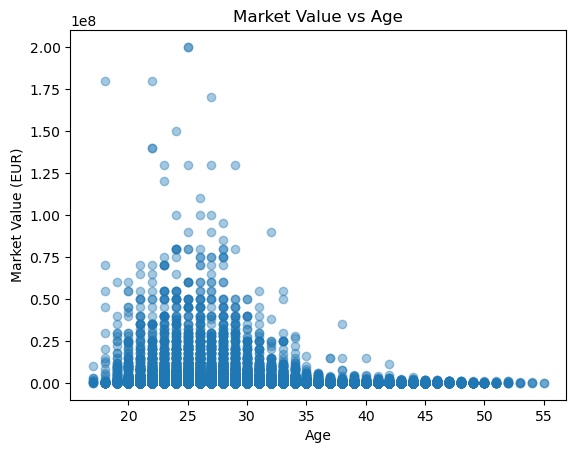

In [4]:
# Plot distribution of target variable
plot_distribution(main_df['market_value_in_eur'].dropna(), title="Market Value (EUR) Distribution")

# Example: Plot Market Value vs Age
plt.figure(figsize=(8,4))
plt.scatter(main_df['last_season'], main_df['market_value_in_eur'], alpha=0.5)
plt.xlabel("Last Season")
plt.ylabel("Market Value (EUR)")
plt.title("Market Value vs Last Season")
plt.show()

# Age vs Value
if 'date_of_birth' in main_df.columns:
    main_df['age'] = 2025 - pd.to_datetime(main_df['date_of_birth']).dt.year
    plt.scatter(main_df['age'], main_df['market_value_in_eur'], alpha=0.4)
    plt.xlabel("Age")
    plt.ylabel("Market Value (EUR)")
    plt.title("Market Value vs Age")
    plt.show()
    



## 4. Feature Engineering

We select and prepare the features we want to use for modeling.  
Categorical variables are encoded, numeric features are scaled, and missing values are handled.


In [5]:
#We need to add an age column, as we would like to use the age as a feature
compute_age(main_df)

# Select features for the model (extend as needed!)
features = [
    'n_games', 'total_yellow', 'total_red',  # From stats
    'age',                                   # Derived
    # Add more features as engineered!
]



cat_features = ['position']  # Example: add position if available

# Handle missing numeric features and scale
X_num = main_df[features].copy()
X_scaled, scaler = fillna_and_scale(X_num, features)

# Encode categorical features if available
if all(col in main_df.columns for col in cat_features):
    X_cat, encoder = encode_categorical(main_df, cat_features)
    # Combine numeric + categorical features
    import numpy as np
    X_full = np.concatenate([X_scaled, X_cat.values], axis=1)
else:
    X_full = X_scaled

# Prepare target variable (log-transform recommended for skew)
y = main_df['market_value_in_eur'].copy()
y = np.log1p(y)  # Use log1p to avoid log(0)


## 5. Train/Test Split

We split our data into training and testing sets to fairly evaluate the model's performance.


In [ ]:
from sklearn.model_selection import train_test_split

# Remove rows with missing targets
valid_idx = ~y.isna()
X_full = X_full[valid_idx]
y = y[valid_idx]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


## 6. Neural Network Regression

We train a simple neural network to predict player market value.


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define a simple MLP model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model (early stopping to avoid overfitting)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


## 7. Model Evaluation

We evaluate the model’s predictions using mean absolute error (MAE) and plot actual vs. predicted values.


In [ ]:
# Predict and reverse log-transform
y_pred = model.predict(X_test).flatten()
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)

print(f"Test MAE: €{mae:,.2f}")
print(f"Test R^2: {r2:.3f}")

# Plot actual vs predicted
scatter_actual_vs_pred(y_test_exp, y_pred_exp, title="Actual vs Predicted Market Value")


## 8. Hyperparameter Tuning (Quick Example)

Let’s briefly show how to tune the network size for better performance.


In [ ]:
# Example: try different layer sizes
results = []
for size in [16, 32, 64, 128]:
    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(size, activation='relu'),
        keras.layers.Dense(size, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    y_pred = model.predict(X_test).flatten()
    y_pred_exp = np.expm1(y_pred)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    results.append((size, mae))

print("Layer size vs MAE:")
for size, mae in results:
    print(f"  {size} units: MAE = €{mae:,.2f}")


## 9. Feature Importance (Optional)

For neural nets, try permutation importance to see which features matter most.


In [ ]:
from sklearn.inspection import permutation_importance

# To use permutation_importance, you need a model with a .predict() method and numpy arrays.
# We'll use a simple baseline regressor for illustration:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
result = permutation_importance(rf, X_test, y_test, n_repeats=5, random_state=42)

# Show top features
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
for idx in indices[:10]:
    print(f"{features[idx]}: {importances[idx]:.4f}")


## 10. Conclusions

We built a neural network model to predict football player market values using stats and personal data.  
Feel free to extend this with more advanced features, more complex models, or deeper analysis!
